In [86]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
def f(x):
    return 3*x**2 - 4*x + 5

In [88]:
f(3.0)

20.0

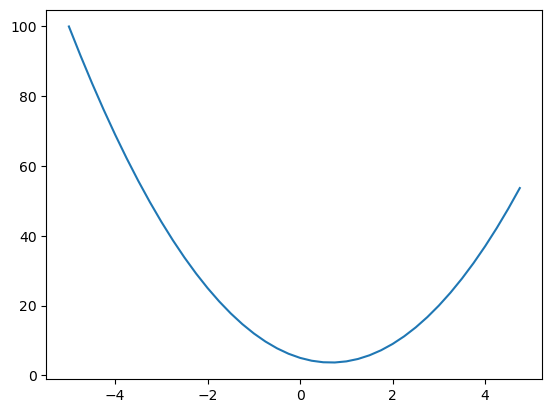

In [89]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [85]:
h = 0.001
x = -3.0
(f(x+h) - f(x))/h

TypeError: 'Value' object is not callable

In [1]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [4]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c # this will be smaller than d1

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) 

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [151]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        

    def __repr__(self):
        return f"Value(data={self.data}, op={self._op})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward # this assigns the instance "_backward" of the class to the reference of the _backward() func
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward # this assigns the instance "_backward" of the class to the reference of the _backward() func
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward # this assigns the instance "_backward" of the class to the reference of the _backward() func
        
        return out

    def backward(self):
        self.grad = 1.0
        
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        for node in reversed(topo):
            node._backward()
            

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0, op=*)

In [53]:
d._prev

{Value(data=-6.0, op=*), Value(data=10.0, op=)}

In [54]:
d._op

'+'

In [74]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

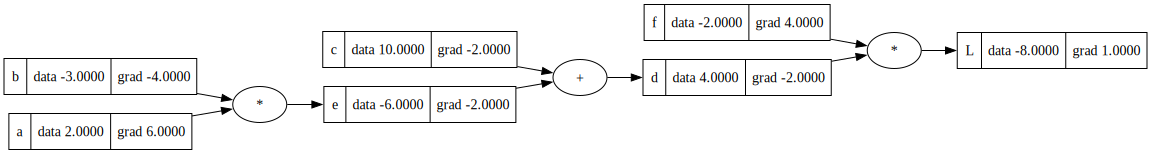

In [78]:
draw_dot(L)

Calculate dL/df

We know that L = d * f
=> dL/df = d and dL/dd = f

Proof:
(f(x + h)-f(x))/h
((d+h)*f-d*h)/h
(d*f+h*f-d*h)/h
f

In [71]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

Calculate dL/dc = dL/dd * dd/dc

We know dL/dd = f = -2.0

We also know d = a*b + c => dd/dc = 1

Proof

(f(x+h) - f(x))/h

(a*b+c+h - a*b -c)/h

h/h = 1

Calculate dL/de = dL/dd * dd/de

d = e + c

=> dd/de = 1

In [76]:
c.grad = -2.0
e.grad = -2.0

With the same logic 

dL/da = dL/dd * dd/de * de/da = -2 * 1 * b = 6.0

dL/db = dL/dd * dd/de * de/db = -2 * 1 * a = -4

In [77]:
a.grad = 6.0
b.grad = -4.0

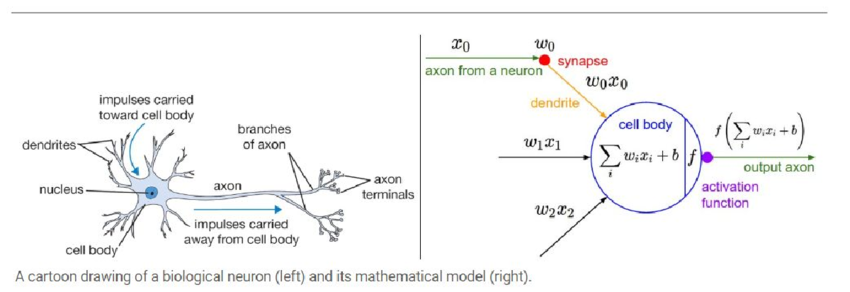![image.png]

Sigmoid function:

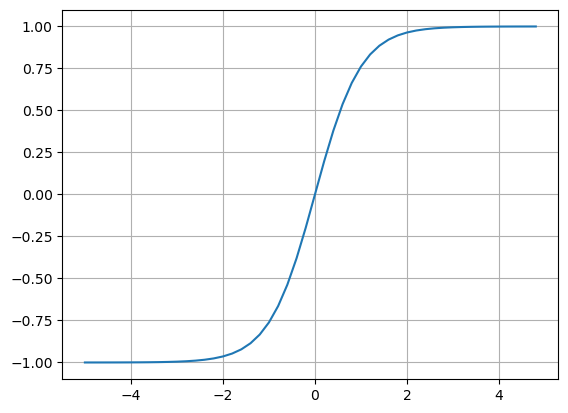

In [90]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [147]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373587019543, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

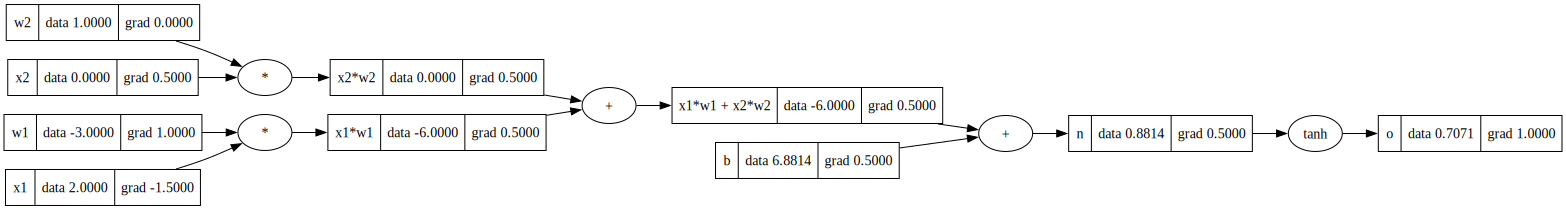

In [150]:
draw_dot(o)

Topological sort

In [149]:
# o.grad = 1.0

# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)

# for node in reversed(topo):
#     node._backward()
o.backward()

We use the _backward() function to calculate gradients

In [127]:
o.grad = 1.0

In [128]:
o._backward()

In [130]:
n._backward()

In [132]:
x1w1x2w2._backward()

In [134]:
x1w1._backward()
x2w2._backward()

Here we are doing it manually

In [108]:
o.grad = 1

In [110]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2
1 - o.data**2

0.4999999999999999

In [111]:
n.grad = 0.5

In [113]:
# n = x1*w1 + x2*w2 + b
#dn/d(x1*w1 + x2*w2) = 1
#do/d(x1*w1 + x2*w2) = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [116]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [120]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [121]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

Some corner cases:

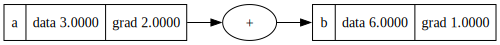

In [152]:

a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

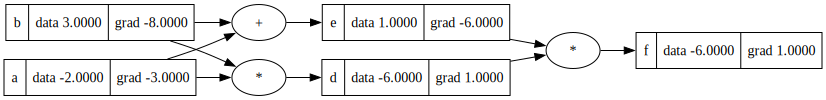

In [153]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)